# Task 2

---

## Predictive modeling of customer bookings
Customers are more empowered than ever because they have access to a wealth of information at their fingertips. This is one of the reasons the buying cycle is very different to what it used to be. Today, if you’re hoping that a customer purchases your flights or holidays as they come into the airport, you’ve already lost! Being reactive in this situation is not ideal; airlines must be proactive in order to acquire customers before they embark on their holiday.

# Problem Statement

* Manipulate and prepare the provided customer booking data so that you can build a high-quality predictive model. This is possible with the use of data and predictive models. The most important factor with a predictive model is the quality of the data you use to train the machine learning algorithms.

* With your predictive model, it is important to interpret the results in order to understand how “predictive” the data really was and whether we can feasibly use it to predict the target outcome (customers buying holidays). Therefore, you should evaluate the model's performance and output how each variable contributes to the predictive model's power.


## Import Necessary Libraries

In [345]:
#!pip install matplotlib==3.4

In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings('ignore')


## Import Dataset

In [347]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

## EDA

### Data understanding & checking missing/null values

In [349]:
#Checking unique values in numerical columns
col = df.columns[df.dtypes!='object']

for i in col:
    x = df[i].unique()
    print(f'{i}: {x}\n')

num_passengers: [2 1 3 4 6 5 7 9 8]

purchase_lead: [262 112 243  96  68   3 201 238  80 378 185   8 265 245 192 259  19  67
 351 228  21  23  25  16  66  51  37 101   7   5  33  20  56  13  71 346
   9  65 221 107  14  77  24  47  22  11  35 272 250 161 128 190 311  27
 314 102   2  26  32  57 198 120  69 281 282  15  31 316 232 156 196 283
  34  63   6 227 181 138 134  85  93 118  90 168 127  18 153 186 263 172
 230  42  81 140 285 179 341 173 180 366 229 174  82  75 163 105 276 110
  83 154  55  45  54 193  10 166  97 239 182  99  53  28 384  70 126 142
  87  86 313  41  91 206 197 268 157 145 241 139  59 396 280  79 380 132
 121 419  58 115 236 225 116 191 275 417 159  92 106 218 295  12 305 235
 332 125 204 310 368 169 214 155 325 130 189 226 122  88 211 188 129 149
  38 194 183  40  95 135 222  64 162 150  73 133  89 151 349  29 123 298
 195  84 410 216 111 109   0 210 326 240  39 294 304 160 363 231  62   1
 178 253  30 199 171 269 301  72 224 246  44  94 113  49 254 296  74 343

In [350]:
#Checking unique values in categorical columns
col = df.columns[df.dtypes=='object']

for i in col:
    x = df[i].unique()
    print(f'{i}: {x}\n')

sales_channel: ['Internet' 'Mobile']

trip_type: ['RoundTrip' 'CircleTrip' 'OneWay']

flight_day: ['Sat' 'Wed' 'Thu' 'Mon' 'Sun' 'Tue' 'Fri']

route: ['AKLDEL' 'AKLHGH' 'AKLHND' 'AKLICN' 'AKLKIX' 'AKLKTM' 'AKLKUL' 'AKLMRU'
 'AKLPEK' 'AKLPVG' 'AKLTPE' 'AORICN' 'AORKIX' 'AORKTM' 'AORMEL' 'BBIMEL'
 'BBIOOL' 'BBIPER' 'BBISYD' 'BDOCTS' 'BDOCTU' 'BDOHGH' 'BDOICN' 'BDOIKA'
 'BDOKIX' 'BDOMEL' 'BDOOOL' 'BDOPEK' 'BDOPER' 'BDOPUS' 'BDOPVG' 'BDOSYD'
 'BDOTPE' 'BDOXIY' 'BKICKG' 'BKICTS' 'BKICTU' 'BKIHND' 'BKIICN' 'BKIKIX'
 'BKIKTM' 'BKIMEL' 'BKIMRU' 'BKIOOL' 'BKIPEK' 'BKIPER' 'BKIPUS' 'BKIPVG'
 'BKISYD' 'BKIXIY' 'BLRICN' 'BLRMEL' 'BLRPER' 'BLRSYD' 'BOMMEL' 'BOMOOL'
 'BOMPER' 'BOMSYD' 'BTJJED' 'BTUICN' 'BTUPER' 'BTUSYD' 'BTUWUH' 'BWNCKG'
 'BWNDEL' 'BWNHGH' 'BWNIKA' 'BWNKTM' 'BWNMEL' 'BWNOOL' 'BWNPER' 'BWNSYD'
 'BWNTPE' 'CANDEL' 'CANIKA' 'CANMEL' 'CANMRU' 'CANOOL' 'CANPER' 'CANSYD'
 'CCUMEL' 'CCUMRU' 'CCUOOL' 'CCUPER' 'CCUSYD' 'CCUTPE' 'CEBMEL' 'CEBOOL'
 'CEBPER' 'CEBSYD' 'CGKCKG' 'CGKCTS' 'CGKCTU' '

In [351]:
#Summary of data for numerical data
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [352]:
#Summary of data for categorical data
df.describe(include='O')

,sales_channel,trip_type,flight_day,route,booking_origin
count,50000,50000,50000,50000,50000
unique,2,3,7,799,104
top,Internet,RoundTrip,Mon,AKLKUL,Australia
freq,44382,49497,8102,2680,17872


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [353]:
#Checking the duplicate data
df[df.duplicated()]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
196,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
316,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
384,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
456,1,Internet,RoundTrip,30,85,15,Fri,AKLKUL,Malaysia,1,0,0,8.83,1
513,3,Internet,RoundTrip,109,20,4,Tue,AKLKUL,Singapore,1,0,1,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49852,2,Internet,RoundTrip,204,6,14,Tue,PENTPE,Malaysia,1,0,0,4.67,0
49902,1,Mobile,RoundTrip,106,6,11,Fri,PENTPE,Taiwan,1,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0


In [354]:
#Dropping the duplicate data
df.drop_duplicates(inplace=True, ignore_index=True)

In [355]:
#Checking the target column count
df.booking_complete.value_counts()

0    41890
1     7391
Name: booking_complete, dtype: int64

In [356]:
#Checking the top 30 coutries & their count
df.booking_origin.value_counts().head(30)

Australia               17691
Malaysia                 7055
South Korea              4502
Japan                    3819
China                    3284
Indonesia                2317
Taiwan                   2042
Thailand                 1993
India                    1258
New Zealand              1060
Singapore                1034
United States             453
Vietnam                   386
Macau                     301
Hong Kong                 294
Philippines               265
United Kingdom            173
Brunei                    161
Cambodia                  131
(not set)                  78
Sri Lanka                  73
Italy                      58
France                     58
Canada                     57
Germany                    54
Myanmar (Burma)            51
Netherlands                45
Mauritius                  43
United Arab Emirates       42
Nepal                      39
Name: booking_origin, dtype: int64

In [357]:
#Checking the sales_channel count
df.sales_channel.value_counts().head(30)

Internet    43917
Mobile       5364
Name: sales_channel, dtype: int64

In [358]:
#Checking the count of trip_type
df.trip_type.value_counts()

RoundTrip     48779
OneWay          386
CircleTrip      116
Name: trip_type, dtype: int64

In [359]:
#Checking the count of flight_days
df.flight_day.value_counts()

Mon    7988
Wed    7562
Tue    7558
Thu    7323
Fri    6685
Sun    6442
Sat    5723
Name: flight_day, dtype: int64

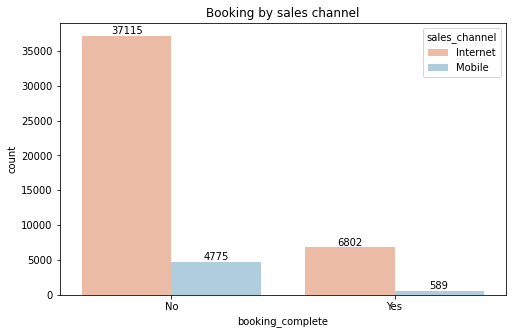

In [360]:
#Visualising the sales_channel by booking status
plt.figure(figsize=(8,5))
ax = sns.countplot(x='booking_complete', data=df, hue='sales_channel', palette='RdBu')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Booking by sales channel')
plt.xticks(ticks = [0,1], labels=['No', 'Yes'])
plt.show()



In [361]:
len(df[df['sales_channel']=='Internet']['booking_complete'])

43917

In [362]:
len(df[(df['sales_channel']=='Internet') & (df['booking_complete']==1)])

6802

In [363]:
len(df[(df['sales_channel']=='Internet') & (df['booking_complete']!=1)])

37115

In [364]:
len(df[df['sales_channel']=='Mobile']['booking_complete'])

5364

In [365]:
len(df[(df['sales_channel']=='Mobile') & (df['booking_complete']!=1)])

4775

In [366]:
len(df[(df['sales_channel']=='Mobile') & (df['booking_complete']==1)])

589

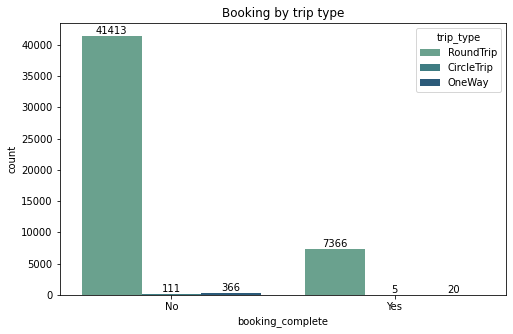

In [367]:
#Visualising the trip_type by booking status
plt.figure(figsize=(8,5))
ax = sns.countplot(x='booking_complete', data=df, hue='trip_type', palette='crest')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Booking by trip type')
plt.xticks(ticks = [0,1], labels=['No', 'Yes'])
plt.show()


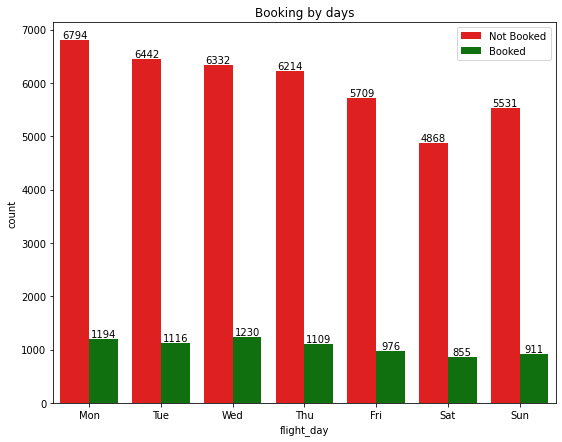

In [368]:
#Visualising the flight_days by booking status
plt.figure(figsize=(9,7))
ax = sns.countplot(x='flight_day', data=df, hue='booking_complete', palette=['red', 'green'],
                   order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
for i in ax.containers:
    ax.bar_label(i)
plt.title('Booking by days')
plt.legend(['Not Booked', 'Booked'])
plt.show()

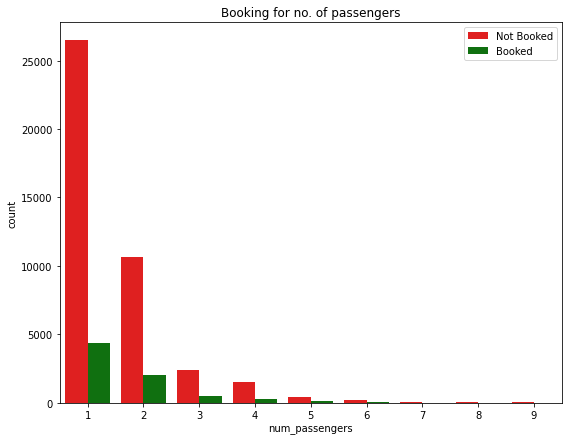

In [369]:
#Visualising the no. of passengers_travel by booking status
plt.figure(figsize=(9,7))
ax = sns.countplot(x='num_passengers', data=df, hue='booking_complete', palette=['red', 'green'],
                   )
#for i in ax.containers:
#    ax.bar_label(i)
plt.title('Booking for no. of passengers')
plt.legend(['Not Booked', 'Booked'])
plt.show()

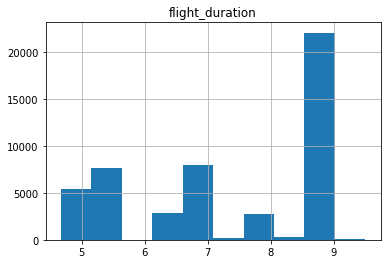

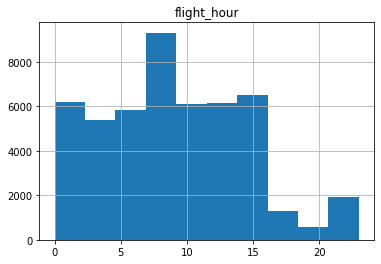

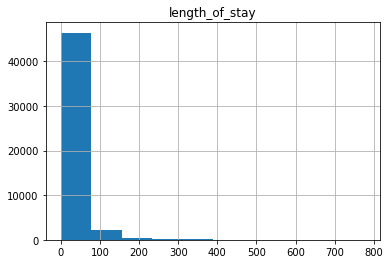

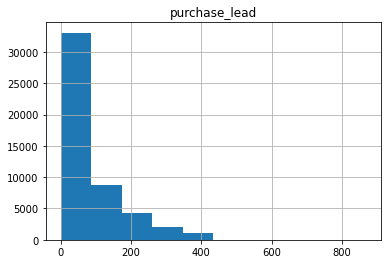

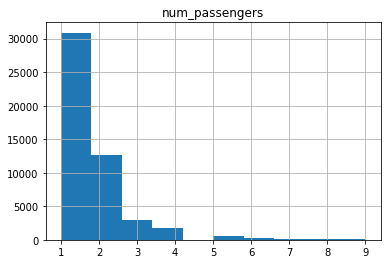

In [370]:
#Checking the distribution of data
coln = ['flight_duration', 'flight_hour', 'length_of_stay', 'purchase_lead'
        ,'num_passengers']

for i in coln:
    df.hist(i)
    plt.title(i)
    plt.show()


In [371]:
#Encoding the column values
day = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7}

sales = {'Internet': 1, 'Mobile':0}

df["sales_channel"] = df["sales_channel"].map(sales)
df["flight_day"] = df["flight_day"].map(day)

In [372]:
#Dropping unnecessary columns
df.drop(['route', 'booking_origin'], inplace=True, axis=1)

In [373]:
#Encoding the categorical column
df = pd.get_dummies(data=df, columns=['trip_type'])
df

,num_passengers,sales_channel,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
0,2,1,262,19,7,6,1,0,0,5.52,0,0,0,1
1,1,1,112,20,3,6,0,0,0,5.52,0,0,0,1
2,2,1,243,22,17,3,1,1,0,5.52,0,0,0,1
3,1,1,96,31,4,6,0,0,1,5.52,0,0,0,1
4,2,1,68,22,15,3,1,0,1,5.52,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49276,2,1,27,6,9,6,1,0,1,5.62,0,0,0,1
49277,1,1,111,6,4,7,0,0,0,5.62,0,0,0,1
49278,1,1,24,6,22,6,0,0,1,5.62,0,0,0,1
49279,1,1,15,6,11,1,1,0,1,5.62,0,0,0,1


Standardizing the data

In [374]:
#Splitting into features & target
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [375]:
#Standardizing the data
sc = StandardScaler()
X = sc.fit_transform(X)

In [376]:
#Checking the shape of data
X.shape, y.shape

((49281, 13), (49281,))

Splitting the data into Train & Test

In [377]:
#Splitting into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=0, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34496, 13), (14785, 13), (34496,), (14785,))

With Imbalanced dataset

In [378]:
#Building the different classification models with default parameters
lr  = LogisticRegression(random_state=0) 
rf  = RandomForestClassifier(n_estimators=100, random_state=0)
xgb = XGBClassifier(n_estimators=100, random_state=0)

In [379]:
#Model Training with above models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier()

Model Testing & Evaluation

In [380]:
y_pred_lr  = lr.predict(X_test) 
y_pred_rf  = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

Analysing the model performance & accuracy 

In [381]:
#Testing the ROC-AUC score for all models
cc  = [y_pred_lr, y_pred_rf, y_pred_xgb]
mod = ['Logistic Regression', 'Random Forest', 'XG Boost']

print('ROC-AUC Scores for all models','\n')

for i,j in zip(cc, mod):
    print('============================')
    print(j, ':', np.round(roc_auc_score(y_test, i)*100, 2))
    print('============================', '\n')

ROC-AUC Scores for all models 

Logistic Regression : 50.0

Random Forest : 51.08

XG Boost : 50.0



Confusion Matrix for all models


Logistic Regression


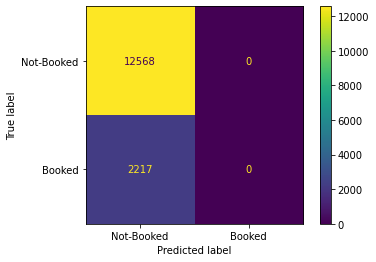



Random Forest


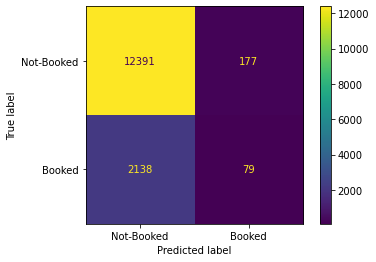



XG Boost


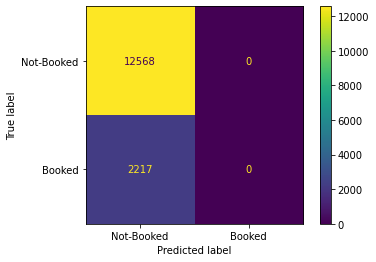

In [382]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Random Forest', 'XG Boost']
dd = [lr, rf, xgb]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test, y_test, display_labels= ['Not-Booked', 'Booked'])   
    plt.show()

In [383]:
#Classification Report for all models
cc  = [y_pred_lr, y_pred_rf, y_pred_xgb]
mod = ['Logistic Regression', 'Random Forest', 'XG Boost']

print('Classification Report for all models','\n')

for i,j in zip(cc, mod):
    print('============================')
    print(j, ':\n\n', (classification_report(y_test, i)))
    print('============================', '\n')

Classification Report for all models 

Logistic Regression :

               precision    recall  f1-score   support

           0       0.85      1.00      0.92     12568
           1       0.00      0.00      0.00      2217

    accuracy                           0.85     14785
   macro avg       0.43      0.50      0.46     14785
weighted avg       0.72      0.85      0.78     14785


Random Forest :

               precision    recall  f1-score   support

           0       0.85      0.99      0.91     12568
           1       0.31      0.04      0.06      2217

    accuracy                           0.84     14785
   macro avg       0.58      0.51      0.49     14785
weighted avg       0.77      0.84      0.79     14785


XG Boost :

               precision    recall  f1-score   support

           0       0.85      1.00      0.92     12568
           1       0.00      0.00      0.00      2217

    accuracy                           0.85     14785
   macro avg       0.43      0.5

Note:
* Poor performance of all models due to imbalanced data.
* The minority class (1) prediction is bad for every model.
* Let's try balancing the dataset and evaluate the model.

#### Note:
*As the dataset is highly imbalance, we will try to balance the dataset by applying various sampling techniques:*
* SMOTE
* SMOTE ENN

## Sampling Techniques

###  SMOTE: Synthetic Minority Over-sampling Technique 
* SMOTE works by selecting pair of minority class observations and then creating a synthetic point that lies on the line connecting these two. It is pretty liberal about selecting the minority points and may end up picking up minority points that are outliers.

In [384]:
#Object Instantiation
sm = SMOTE(random_state=0)

In [385]:
#Resampling the dataset with smote
X_res, y_res = sm.fit_resample(X, y)

In [386]:
#Rechecking the count of target variable after smote
print('X_res after resampling shape : ' , X_res.shape)
print('y_res after resampling shape : ' , y_res.shape, '\n')
print(y_res.value_counts())

X_res after resampling shape :  (83780, 13)
y_res after resampling shape :  (83780,) 

0    41890
1    41890
Name: booking_complete, dtype: int64


#### Building models with balanced data (smote_resampled data)

In [387]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0, test_size=0.3, stratify=y_res)

In [388]:
#Checking the size of features
X_train_res.shape, X_test_res.shape

((58646, 13), (25134, 13))

#### Model Building with default parameters & smote_resampled data

In [389]:
lr_mod2  = LogisticRegression(random_state=0)
rf_mod2  = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=0)
xgb_mod2 = XGBClassifier(n_estimators=100, random_state=0)

#### Model Training

In [390]:
%%time
lr_mod2.fit(X_train_res, y_train_res)
rf_mod2.fit(X_train_res, y_train_res)
xgb_mod2.fit(X_train_res, y_train_res)

CPU times: user 12.6 s, sys: 181 ms, total: 12.8 s
Wall time: 12.6 s


XGBClassifier()

#### Model Testing & Evaluation

In [391]:
%%time
y_pred_lr2  = lr_mod2.predict(X_test_res)
y_pred_rf2  = rf_mod2.predict(X_test_res)
y_pred_xgb2 = xgb_mod2.predict(X_test_res)

CPU times: user 914 ms, sys: 102 ms, total: 1.02 s
Wall time: 909 ms


In [392]:
#Testing the roc-auc score for all models
cc = [y_pred_lr2, y_pred_rf2, y_pred_xgb2]
mm = ['Logistic Regression', 'Random Forest', 'XGB']

print('ROC-AUC score for all models')

for i,j in zip(cc, mm):
    print('\n====================================')
    print(j, ':', roc_auc_score(y_test_res, i).round(2))
    print('====================================', '\n')

ROC-AUC score for all models

Logistic Regression : 0.6


Random Forest : 0.9


XGB : 0.84



Confusion Matrix for all models


Logistic Regression


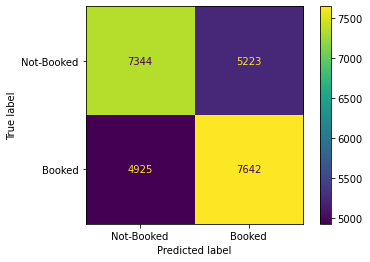



Random Forest


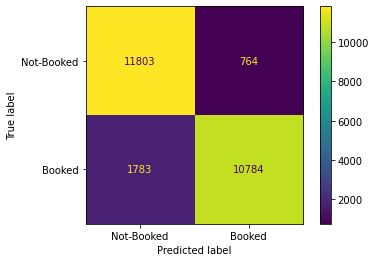



XGB


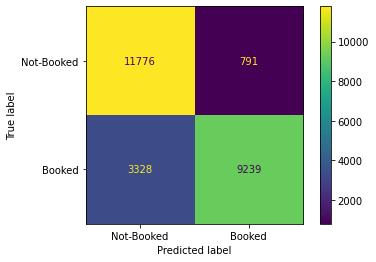

In [393]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Random Forest', 'XGB']
dd = [lr_mod2 ,rf_mod2, xgb_mod2]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_res, y_test_res, display_labels= ['Not-Booked', 'Booked'])   
    plt.show()

In [394]:
#Classification Report for all models
cc = [y_pred_lr2, y_pred_rf2, y_pred_xgb2]
mm = ['Logistic Regression', 'Random Forest', 'XGB']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_res, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.60      0.58      0.59     12567
           1       0.59      0.61      0.60     12567

    accuracy                           0.60     25134
   macro avg       0.60      0.60      0.60     25134
weighted avg       0.60      0.60      0.60     25134


Random Forest 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     12567
           1       0.93      0.86      0.89     12567

    accuracy                           0.90     25134
   macro avg       0.90      0.90      0.90     25134
weighted avg       0.90      0.90      0.90     25134


XGB 
               precision    recall  f1-score   support

           0       0.78      0.94      0.85     12567
           1       0.92      0.74      0.82     12567

    accuracy                           0.84     25134
   macro avg       0.85      0.84      0.83     25134
weighted avg       0.85     

In [395]:
#Comparing the models imbalance & model smote_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [roc_auc_score(y_test ,y_pred_lr).round(2), roc_auc_score(y_test ,y_pred_rf).round(2), roc_auc_score(y_test ,y_pred_xgb).round(2)], 
                                                                      'Model2': [roc_auc_score(y_test_res ,y_pred_lr2).round(2), roc_auc_score(y_test_res ,y_pred_rf2).round(2), roc_auc_score(y_test_res ,y_pred_xgb2).round(2)]
                                                                       })
mod_comp['%Change in Score'] = mod_comp['Model2'] - mod_comp['Model1']
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Score
Random Forest,0.51,0.90,0.39
XGB,0.50,0.84,0.34
Logistic Regression,0.50,0.60,0.10


Note:
* All models performed better as compared to their performance on imbalanced dataset.
* Random Forest outperformed all models by minimising the misclassification to great extent. The F1 score for RF is good than other models.

## SMOTE-ENN
ENN method works by finding the K-nearest neighbor of each observation first, then check whether the majority class from the observation’s k-nearest neighbor is the same as the observation’s class or not. If the majority class of the observation’s K-nearest neighbor and the observation’s class is different, then the observation and its K-nearest neighbor are deleted from the dataset.

In [396]:
#Object Instantiation
se = SMOTEENN(random_state=0)

In [397]:
#Resampling the dataset with smote-enn
X_se, y_se = se.fit_resample(X, y)

In [398]:
##Rechecking the count of target variable after smote-enn
print('X_res after resampling shape : ' , X_se.shape)
print('y_res after resampling shape : ' , y_se.shape, '\n')
print(y_se.value_counts())

X_res after resampling shape :  (56019, 13)
y_res after resampling shape :  (56019,) 

1    33215
0    22804
Name: booking_complete, dtype: int64


#### Building models with balanced data (SMOTE + ENN)

In [399]:
#Splitting data into training and testing dataset with 80:20 ratio
X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(X_se, y_se, random_state=0, test_size=0.35, stratify=y_se)

In [400]:
#Checking the size of features
X_train_se.shape, X_test_se.shape

((36412, 13), (19607, 13))

#### Model Building with default parameters & smote-enn_resampled data

In [401]:
lr_mod3  = LogisticRegression(random_state=0)
rf_mod3  = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=0)
xgb_mod3 = XGBClassifier(n_estimators=100, random_state=0)

#### Model Training

In [402]:
%%time
lr_mod3.fit(X_train_se, y_train_se)
rf_mod3.fit(X_train_se, y_train_se)
xgb_mod3.fit(X_train_se, y_train_se)

CPU times: user 7.55 s, sys: 162 ms, total: 7.72 s
Wall time: 7.56 s


XGBClassifier()

#### Model Testing & Evaluation

In [403]:
%%time
y_pred_lr3  = lr_mod3.predict(X_test_se)
y_pred_rf3  = rf_mod3.predict(X_test_se)
y_pred_xgb3 = xgb_mod3.predict(X_test_se)

CPU times: user 639 ms, sys: 85.5 ms, total: 724 ms
Wall time: 628 ms


In [404]:
#Testing the roc-auc score for all models
cc = [y_pred_lr3, y_pred_rf3, y_pred_xgb3]
mm = ['Logistic Regression', 'Random Forest', 'XGB']

print('ROC-AUC score for all models')

for i,j in zip(cc, mm):
    print('\n====================================')
    print(j, ':', roc_auc_score(y_test_se, i).round(2))
    print('====================================', '\n')

ROC-AUC score for all models

Logistic Regression : 0.62


Random Forest : 0.93


XGB : 0.84



Confusion Matrix for all models


Logistic Regression


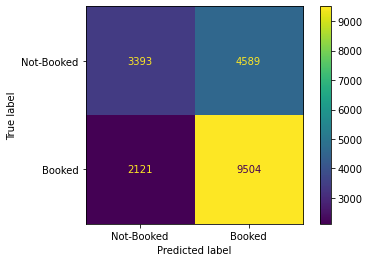



Random Forest


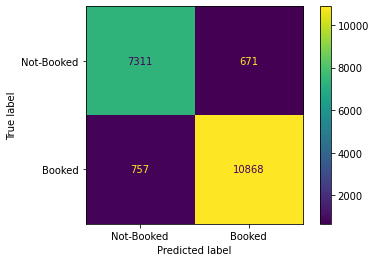



XGB


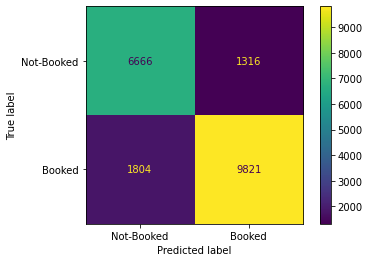

In [405]:
#Plotting Confusion Matrix for all models
mm = ['Logistic Regression', 'Random Forest', 'XGB']
dd = [lr_mod3, rf_mod3, xgb_mod3]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_se, y_test_se, display_labels= ['Not-Booked', 'Booked'], values_format = 'g')   
    plt.show()

In [406]:
#Classification Report for all models
cc = [y_pred_lr3, y_pred_rf3, y_pred_xgb3]
mm = ['Logistic Regression', 'Random Forest', 'XGB']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_se, i))
    print('======================================================', '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.62      0.43      0.50      7982
           1       0.67      0.82      0.74     11625

    accuracy                           0.66     19607
   macro avg       0.64      0.62      0.62     19607
weighted avg       0.65      0.66      0.64     19607


Random Forest 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      7982
           1       0.94      0.93      0.94     11625

    accuracy                           0.93     19607
   macro avg       0.92      0.93      0.92     19607
weighted avg       0.93      0.93      0.93     19607


XGB 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      7982
           1       0.88      0.84      0.86     11625

    accuracy                           0.84     19607
   macro avg       0.83      0.84      0.84     19607
weighted avg       0.84     

In [407]:
#Comparing the models imbalance & model smote_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['Model1', 'Model2'], data={'Model1': [roc_auc_score(y_test ,y_pred_lr).round(2), roc_auc_score(y_test ,y_pred_rf).round(2), roc_auc_score(y_test ,y_pred_xgb).round(2)], 
                                                                      'Model2': [roc_auc_score(y_test_se ,y_pred_lr3).round(2), roc_auc_score(y_test_se ,y_pred_rf3).round(2), roc_auc_score(y_test_se ,y_pred_xgb3).round(2)]
                                                                       })
mod_comp['%Change in Score'] = mod_comp['Model2'] - mod_comp['Model1']
mod_comp.sort_values(by='Model2', ascending=False)

,Model1,Model2,%Change in Score
Random Forest,0.51,0.93,0.42
XGB,0.50,0.84,0.34
Logistic Regression,0.50,0.62,0.12


Note:
* As compared to SMOTE balanced data, Random Forest performance has improved with SMOTEENN. 
* Other model's performance has dipped compared to their performance on SMOTE balanced data.
* Random Forest model's F1 score is high. 

### We build above models with all features taken into consideration to predict whether bookings will complete or not. Let's try building models considering only significant features to predict the bookings. 

## Feature Engineering
*To determine the important features for the model*
* Correlation Analysis
* Recursive Feature Elimination (RFE)
* Random Forest, XGBoost feature importance

### Correlation Analysis

In [408]:
#Making a copy of data, retrieving the column names
df1 = df.copy()
df1.drop('booking_complete', axis=1, inplace=True)
X_cols = df1.columns
X_cols.shape

(13,)

In [409]:
#Making a dataframe for features & target column - imbalance data
df2 = pd.DataFrame(X, columns=X_cols)
df2['booking_complete'] = y
df2.shape

(49281, 14)

In [410]:
#Making a dataframe for features & target column - smote+enn balanced data
df3 = pd.DataFrame(X_se, columns=X_cols)
df3['booking_complete'] = y_se
df3.shape

(56019, 14)

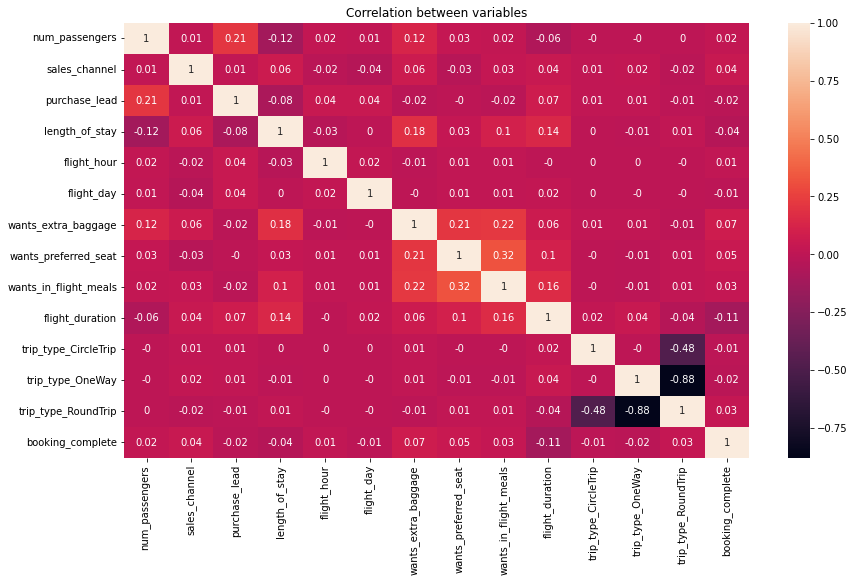

In [411]:
#Correlation Analysis in visual form - imbalance data
plt.figure(figsize=(14,8))
sns.heatmap(df2.corr().round(2), annot=True)
plt.title('Correlation between variables')
plt.show()

In [412]:
#Analysis of correlation between target & feature variables - imbalance data
df2.corr()['booking_complete'].sort_values().round(2)

flight_duration         -0.11
length_of_stay          -0.04
trip_type_OneWay        -0.02
purchase_lead           -0.02
trip_type_CircleTrip    -0.01
flight_day              -0.01
flight_hour              0.01
num_passengers           0.02
wants_in_flight_meals    0.03
trip_type_RoundTrip      0.03
sales_channel            0.04
wants_preferred_seat     0.05
wants_extra_baggage      0.07
booking_complete         1.00
Name: booking_complete, dtype: float64

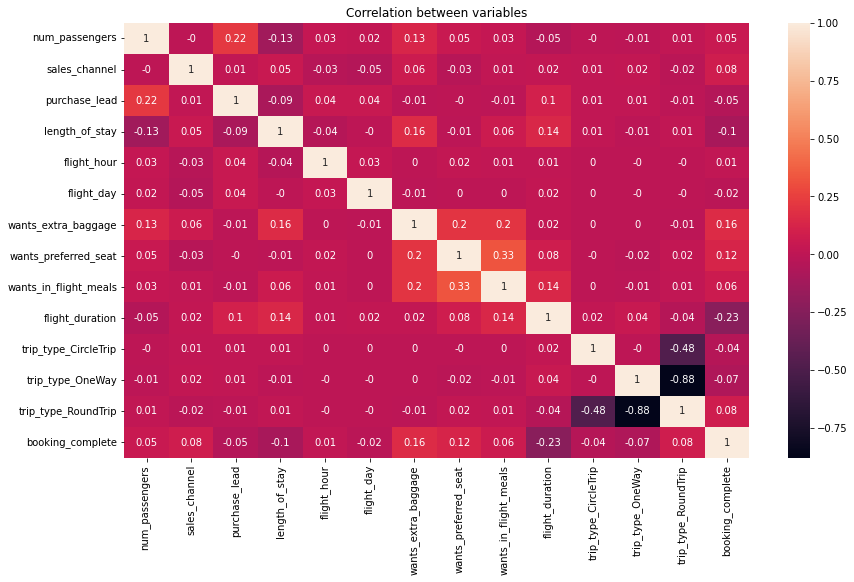

In [413]:
##Correlation Analysis in visual form - smote+enn balance data
plt.figure(figsize=(14,8))
sns.heatmap(df3.corr().round(2), annot=True)
plt.title('Correlation between variables')
plt.show()

In [414]:
#Analysis of correlation between target & feature variables - smote+enn balance data
df3.corr()['booking_complete'].sort_values().round(2)

flight_duration         -0.23
length_of_stay          -0.10
trip_type_OneWay        -0.07
purchase_lead           -0.05
trip_type_CircleTrip    -0.04
flight_day              -0.02
flight_hour              0.01
num_passengers           0.05
wants_in_flight_meals    0.06
trip_type_RoundTrip      0.08
sales_channel            0.08
wants_preferred_seat     0.12
wants_extra_baggage      0.16
booking_complete         1.00
Name: booking_complete, dtype: float64

#### From correlational analysis,
* num_passengers, purchase_lead, flight_hour, flight_day, trip_type_CircleTrip & wants_in_flight_meals is having low-correlation w.r.t booking_type.

* flight_duration, wants_preferred_seat, wants_extra_baggage, length_of_stay are top 5 features having high correlation w.r.t booking_type.

* Rest all features have a good correlation w.r.t booking_type.

### Recursive Feature Elimination (RFE)

In [415]:
#Drawing Important features from Random Forest model using RFE
rfe_rf  = RFE(rf_mod3)

In [416]:
rfe_rf.fit(X_se, y_se)

RFE(estimator=RandomForestClassifier(random_state=0))

In [417]:
#Important features as per random forest model
rfe_rf.get_feature_names_out(df2.columns[:-1])

array(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'flight_duration'], dtype=object)

In [418]:
#Drawing Important features from Extreme Gradient Boosting model using RFE
rfe_xgb = RFE(xgb_mod3)

In [419]:
rfe_xgb.fit(X_se, y_se)

RFE(estimator=XGBClassifier())

In [420]:
#Important features as per extreme gradient boost model
rfe_xgb.get_feature_names_out(df2.columns[:-1])

array(['sales_channel', 'length_of_stay', 'flight_day',
       'wants_extra_baggage', 'wants_preferred_seat', 'flight_duration'],
      dtype=object)

In [421]:
#Comparing all the features from 3 models in a DataFrame
rfe_df = pd.DataFrame({'Random Forest' : rfe_rf.get_feature_names_out(df2.columns[:-1]),
                       'Extreme Gradient Boost' : rfe_xgb.get_feature_names_out(df2.columns[:-1])})
rfe_df

,Random Forest,Extreme Gradient Boost
0,num_passengers,sales_channel
1,purchase_lead,length_of_stay
2,length_of_stay,flight_day
3,flight_hour,wants_extra_baggage
4,flight_day,wants_preferred_seat
5,flight_duration,flight_duration


#### From above RFE analysis,
* 'length_of_stay', 'flight_day', 'flight_duration' are common significant features for Random Forest & Extreme Gradient models.

### Random Forest Feature Importance

In [422]:
#Drawing Important features from Random Forest model
rf_feat = rf_mod3.feature_importances_

In [423]:
#Making a dataframe for random forest feature importance
rfi = pd.DataFrame({'Features' :  df2.columns[:-1], 
                    'Values'   :  rf_feat.round(2)})
rfi.sort_values(by = 'Values', ascending = False, ignore_index = True)

,Features,Values
0,length_of_stay,0.22
1,flight_duration,0.22
2,purchase_lead,0.15
3,flight_hour,0.15
4,flight_day,0.11
5,num_passengers,0.05
6,wants_extra_baggage,0.04
7,sales_channel,0.02
8,wants_preferred_seat,0.02
9,wants_in_flight_meals,0.02


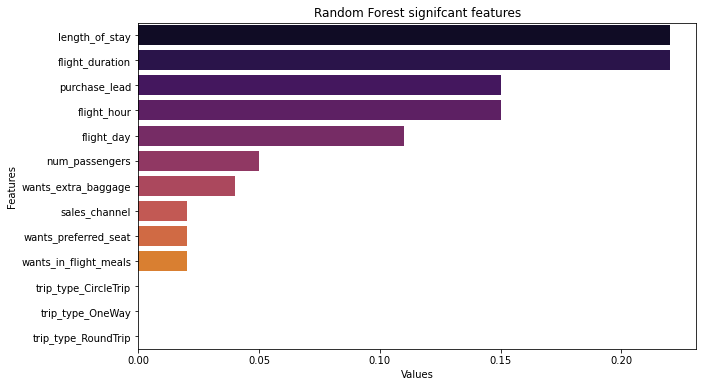

In [424]:
#Visualisng the significant features
plt.figure(figsize=(10,6))
sns.barplot(data=rfi, x='Values', y='Features', order=rfi.sort_values('Values', ascending=False)['Features'], palette='inferno')
plt.title('Random Forest signifcant features')
plt.show()

Note:
* From above analysis, length_of_stay, flight_duration, purchase_lead, flight_hour, flight_day, num_passengers & wants_extra_baggage are the significant features as per random forest feature importance.

XGBoost Feature Importance

In [425]:
#Drawing Important features from XGBoost model
xgb_feat = xgb_mod3.feature_importances_

In [426]:
#Making a dataframe for XGBoost feature importance
xgbi = pd.DataFrame({'Features' :  df2.columns[:-1], 
                    'Values'   :  xgb_feat.round(2)})
xgbi.sort_values(by = 'Values', ascending = False, ignore_index = True)

,Features,Values
0,flight_duration,0.19
1,wants_extra_baggage,0.17
2,length_of_stay,0.16
3,flight_day,0.12
4,sales_channel,0.07
5,flight_hour,0.07
6,wants_preferred_seat,0.07
7,trip_type_RoundTrip,0.06
8,num_passengers,0.03
9,purchase_lead,0.03


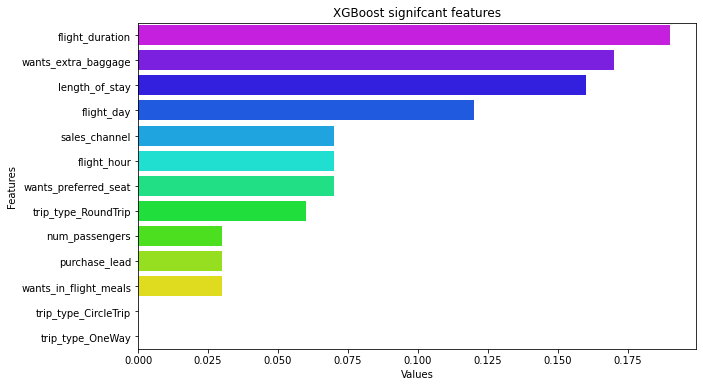

In [427]:
#Visualisng the significant features
plt.figure(figsize=(10,6))
sns.barplot(data=xgbi, x='Values', y='Features', order=xgbi.sort_values('Values', ascending=False)['Features'], palette='gist_rainbow_r')
plt.title('XGBoost signifcant features')
plt.show()

Note:
* From above analysis, flight_duration, wants_extra_baggage, length_of_stay, flight_day, sales_channel, flight_hour & wants_preferred_seat are the significant features as per XGBoost feature importance.

## Building Model based on 7 significant features & smote-enn balanced sampled data

In [428]:
#Preparing two separate dataframe for train & test
data2 = pd.DataFrame(data = X_train_se, columns = X_cols)
data3 = pd.DataFrame(data = X_test_se, columns = X_cols)

In [429]:
#Selecting only 7 significant features for training
X_train_fi = data2.loc[:, ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'flight_duration', 'wants_extra_baggage']]

In [430]:
#Selecting only 7 significant features for tetsing
X_test_fi = data3.loc[:, ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'flight_duration', 'wants_extra_baggage']]

In [431]:
#Size of train data
X_train_fi.shape, y_train_se.shape

((36412, 7), (36412,))

In [432]:
#Size of test data
X_test_fi.shape, y_test_se.shape

((19607, 7), (19607,))

In [433]:
#Model Building
rf_mod4  = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=0)
xgb_mod4 = XGBClassifier(n_estimators=100, random_state=0)

### Model Training

In [434]:
%%time
rf_mod4.fit(X_train_fi, y_train_se)
xgb_mod4.fit(X_train_fi, y_train_se)

CPU times: user 7.22 s, sys: 13.1 ms, total: 7.23 s
Wall time: 7.22 s


XGBClassifier()

### Model Testing & Evaluation

In [435]:
%%time
y_pred_rf4  = rf_mod4.predict(X_test_fi)
y_pred_xgb4 = xgb_mod4.predict(X_test_fi)

CPU times: user 569 ms, sys: 3.78 ms, total: 573 ms
Wall time: 573 ms


In [436]:
#Testing the roc-auc score for all models
cc = [y_pred_rf4, y_pred_xgb4]
mm = ['Random Forest', 'XGB']

print('ROC-AUC score for all models')

for i,j in zip(cc, mm):
    print('\n====================================')
    print(j, ':', roc_auc_score(y_test_se, i).round(2))
    print('====================================', '\n')

ROC-AUC score for all models

Random Forest : 0.9


XGB : 0.84



Confusion Matrix for all models


Random Forest


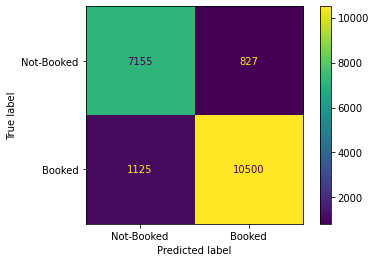



XGB


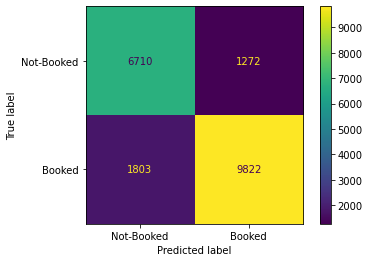

In [437]:
#Plotting Confusion Matrix for all models
mm = ['Random Forest', 'XGB']
dd = [rf_mod4, xgb_mod4]

print('Confusion Matrix for all models')

for i,j in zip(dd, mm):
    print('\n','========================================', '\n')
    print(j)
    plot_confusion_matrix(i, X_test_fi, y_test_se, display_labels= ['Not-Booked', 'Booked'], values_format = 'g')   
    plt.show()

In [438]:
#Classification Report for all models
cc = [y_pred_rf4, y_pred_xgb4]
mm = ['Random Forest', 'XGB']

for i,j in zip(cc, mm):
    print('======================================================')
    print(j, '\n', classification_report(y_test_se, i))
    print('======================================================', '\n')

Random Forest 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      7982
           1       0.93      0.90      0.91     11625

    accuracy                           0.90     19607
   macro avg       0.90      0.90      0.90     19607
weighted avg       0.90      0.90      0.90     19607


XGB 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      7982
           1       0.89      0.84      0.86     11625

    accuracy                           0.84     19607
   macro avg       0.84      0.84      0.84     19607
weighted avg       0.85      0.84      0.84     19607




In [439]:
#Comparing the models imbalance & model smote_balance data with balanced accuracy score
mod_comp = pd.DataFrame(index=mm, columns=['All 19 Feat.', '7 Feat.'], data={'All 19 Feat.': [roc_auc_score(y_test_se ,y_pred_rf3).round(2),  roc_auc_score(y_test_se ,y_pred_xgb3).round(2)], 
                                                                      '7 Feat.': [roc_auc_score(y_test_se ,y_pred_rf4).round(2),  roc_auc_score(y_test_se ,y_pred_xgb4).round(2)]
                                                                       })
mod_comp['%Change in Score'] = mod_comp['7 Feat.'] - mod_comp['All 19 Feat.']

mod_comp.sort_values(by = '7 Feat.', ascending = False)

,All 19 Feat.,7 Feat.,%Change in Score
Random Forest,0.93,0.90,-0.03
XGB,0.84,0.84,0.00


Note:
* We can finalise, Random Forest model for our dataset.
* Random Forest model has outperformed compared to XGBoost model with SMOTE as well as SMOTEENN balanced data with all features vs 7 significant features.
* As we can see, with 7 significant features Random forest model is still stable with around 90% accuracy.

Thank you!!